# Calculate the angle of the C2B principal axis along a trajectory

This includes two main angles: (1) the alignment angle between the principal component of the C2 domains (with a defined orientation) ang (2) the rotational angle of the C2 domain along the principal axis.

In [1]:
from MDAnalysis import *
import MDAnalysis.analysis.pca as pca
from MDAnalysis import transformations

import nglview as nv
import numpy as np
import os
import pickle

import scipy
print('Using SciPy Version {}:'.format(scipy.__version__))
from scipy.spatial import KDTree

import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objs as go

# ignore deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

universes = [(('../sv_membrane/c2b_only/0_deg_new/parse_traj_1500ns_nowater.gro', '../sv_membrane/c2b_only/0_deg_new/parse_traj_1500ns_nowater.xtc'), 'SV', '0deg'),
             (('../sv_membrane/c2b_only/30_deg/parse_traj_1500ns_nowater.gro', '../sv_membrane/c2b_only/30_deg/parse_traj_1500ns_nowater.xtc'), 'SV', '30deg'),
             (('../sv_membrane/c2b_only/60_deg/parse_traj_1500ns_nowater.gro', '../sv_membrane/c2b_only/60_deg/parse_traj_1500ns_nowater.xtc'), 'SV', '60deg'),
#
             (('../sv_membrane/c2b_ca/0_deg/parse_traj_1500ns_nowater.gro', '../sv_membrane/c2b_ca/0_deg/parse_traj_1500ns_nowater.xtc'), 'SV Ca', '0deg'),
             (('../sv_membrane/c2b_ca/30_deg/parse_traj_1500ns_nowater.gro', '../sv_membrane/c2b_ca/30_deg/parse_traj_1500ns_nowater.xtc'), 'SV Ca', '30deg'),
             (('../sv_membrane/c2b_ca/60_deg/parse_traj_1500ns_nowater.gro', '../sv_membrane/c2b_ca/60_deg/parse_traj_1500ns_nowater.xtc'), 'SV Ca', '60deg'),
#            
             (('../pm_membrane/c2b_only/0_deg_new/parse_traj_1500ns_nowater.gro', '../pm_membrane/c2b_only/0_deg_new/parse_traj_1500ns_nowater.xtc'), 'PM', '0deg'),
             (('../pm_membrane/c2b_only/30_deg/parse_traj_1500ns_nowater.gro', '../pm_membrane/c2b_only/30_deg/parse_traj_1500ns_nowater.xtc'), 'PM', '30deg'),
             (('../pm_membrane/c2b_only/60_deg/parse_traj_1500ns_nowater.gro', '../pm_membrane/c2b_only/60_deg/parse_traj_1500ns_nowater.xtc'), 'PM', '60deg'),
#
             (('../pm_membrane/c2b_ca/0_deg/parse_traj_1500ns_nowater.gro', '../pm_membrane/c2b_ca/0_deg/parse_traj_1500ns_nowater.xtc'), 'PM Ca', '0deg'),
             (('../pm_membrane/c2b_ca/30_deg/parse_traj_1500ns_nowater.gro', '../pm_membrane/c2b_ca/30_deg/parse_traj_1500ns_nowater.xtc'), 'PM Ca', '30deg'),
             (('../pm_membrane/c2b_ca/60_deg/parse_traj_1500ns_nowater.gro', '../pm_membrane/c2b_ca/60_deg/parse_traj_1500ns_nowater.xtc'), 'PM Ca', '60deg')]

Using SciPy Version 1.10.1:


In [2]:
# As the main interest is the inclination of the domains with respect to the bilayer (i.e. the xy plane)
# the main reference vector is
ref_vec = np.array([0,0,1])

In [3]:
def lsq(ag):
    """Return first component of SVD of positions (i.e. the least squares linear fit)"""
    data = ag.positions

    # Calculate the mean of the points, i.e. the 'center' of the cloud
    datamean = data.mean(axis=0)

    # Do an SVD on the mean-centered data.
    uu, dd, vv = np.linalg.svd(data - datamean)

    return vv[0]

In [4]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return 180 * np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)) / np.pi

In [5]:
times_and_angles = []

for files in universes:

    print("Reading files from:\n{}".format(*files[0]))
    u = Universe(*files[0], in_memory=True)
    ag = u.select_atoms('name CA and protein')
    #selg = u.select_atoms('resid 34 and protein')
    # use pro39 instead of 34 as it is not involved in a flexible loop
    selg = u.select_atoms('resid 39 and protein')
    # use tyr11 instead of COM as better defined
    selg2 = u.select_atoms('resid 11 and protein')
    
    a1_eigh = []
    a1_svd = []
    a1_atoms = []
    time = []
    
    u.trajectory.add_transformations(transformations.center_in_box(ag,center='mass'))
    
    for ts in u.trajectory:
        
        p1_eigh = ag.principal_axes()[0]
        p1_svd = lsq(ag)
        # p1_atoms = ag.center_of_mass() - selg.center_of_mass()
        p1_atoms = selg2.center_of_mass() - selg.center_of_mass()
        
        a1_eigh.append(angle_between(ref_vec, p1_eigh))
        a1_svd.append(angle_between(ref_vec, p1_svd))
        a1_atoms.append(angle_between(ref_vec, p1_atoms))
        
        time.append(ts.time/1000)
    
    # calculate the time as remaining time before trajectory end
    time = np.array(time)
    time = time - time.max()
        
    midx = pd.MultiIndex.from_tuples([files[-2:],]
                                    )
    midx.names = ['membrane', 'condition']
    
    times_and_angles.append(pd.DataFrame(index=time, data=a1_atoms,
                                         columns=midx))

Reading files from:
../sv_membrane/c2b_only/0_deg_new/parse_traj_1500ns_nowater.gro
Reading files from:
../sv_membrane/c2b_only/30_deg/parse_traj_1500ns_nowater.gro
Reading files from:
../sv_membrane/c2b_only/60_deg/parse_traj_1500ns_nowater.gro
Reading files from:
../sv_membrane/c2b_ca/0_deg/parse_traj_1500ns_nowater.gro
Reading files from:
../sv_membrane/c2b_ca/30_deg/parse_traj_1500ns_nowater.gro
Reading files from:
../sv_membrane/c2b_ca/60_deg/parse_traj_1500ns_nowater.gro
Reading files from:
../pm_membrane/c2b_only/0_deg_new/parse_traj_1500ns_nowater.gro
Reading files from:
../pm_membrane/c2b_only/30_deg/parse_traj_1500ns_nowater.gro
Reading files from:
../pm_membrane/c2b_only/60_deg/parse_traj_1500ns_nowater.gro
Reading files from:
../pm_membrane/c2b_ca/0_deg/parse_traj_1500ns_nowater.gro
Reading files from:
../pm_membrane/c2b_ca/30_deg/parse_traj_1500ns_nowater.gro
Reading files from:
../pm_membrane/c2b_ca/60_deg/parse_traj_1500ns_nowater.gro


In [6]:
# Check if centering worked
view = nv.show_mdanalysis(u)
view.add_unitcell()
view.add_representation("spacefill", selection="(39 or 11) and protein")
view

NGLWidget(max_frame=1500)

In [7]:
angles_df = pd.concat(times_and_angles, axis=1)
angles_df

membrane          SV                            SV Ca                         \
condition       0deg      30deg      60deg       0deg       30deg      60deg   
-1496.0    16.958224  48.331721  90.859409  41.093348   17.655965        NaN   
-1495.0    14.312299  55.115601  88.585947  50.845320   30.966603        NaN   
-1494.0    16.854624  43.359658  87.478113  37.995578   40.988897  68.707620   
-1493.0     7.555606  68.120326  83.306923  55.619093   45.581701  79.314224   
-1492.0    21.479547  59.669783  90.356832  54.253757   66.342108  79.172686   
...              ...        ...        ...        ...         ...        ...   
 0.0       86.470392  96.571991  89.206804  97.886480  110.441793  54.667933   
-1500.0          NaN        NaN  70.198372  18.275683   29.535668        NaN   
-1499.0          NaN        NaN  94.321327  21.207473   24.627792        NaN   
-1498.0          NaN        NaN  84.728408  16.529194   29.370340        NaN   
-1497.0          NaN        NaN  91.103427  41.505212   15.267415        NaN   

membrane          PM                            PM Ca                        
condition       0deg      30deg      60deg       0deg      30deg      60deg  
-1496.0    35.983396        NaN  62.117266  45.063692  63.291549  49.231643  
-1495.0    38.608782        NaN  65.910729  26.112414  48.092841  42.187372  
-1494.0    39.452224        NaN  48.412625  44.881999  62.098897  48.761689  
-1493.0    57.187770        NaN  42.061754  40.797668  62.249675  52.120702  
-1492.0    53.133310        NaN  16.395963  47.042388  62.026579  59.035858  
...              ...        ...        ...        ...        ...        ...  
 0.0       99.070706  75.483872  94.864305  87.987218  71.518580  73.296177  
-1500.0     6.450525        NaN  54.912830  22.376292  27.181593  58.427500  
-1499.0    25.887088        NaN  50.999197  32.313090  37.299336  54.509712  
-1498.0    25.816594        NaN  56.337414  16.594199  42.390259  47.782382  
-1497.0    35.817094        NaN  70.304274  19.553543  52.189784  50.949061  

[1501 rows x 12 columns]

In [8]:
def save_figures(fig, fpath):
    """
    Saves html, png and pdf versions of a figure to a specified path
    Use fpath without file extension.
    """
    fpath = os.path.abspath(fpath)
    
    fig.update_layout(template='presentation'),
    # png file
    fig.write_image(fpath + '.png', width=800, height=800)
    
    # pdf file
    fig.update_layout(template='simple_white'),
    fig.write_image(fpath + '.pdf')

    #html file    
    plotly.offline.plot(fig, filename=fpath + '.html', auto_open=False)
    fig.show()

    return fig

In [9]:
for name, data in angles_df.groupby(level=0, axis=1):
    data.columns = data.columns.get_level_values(level=1)
    fig = px.line(data,
                 title=name,
                 template='simple_white',
                 labels={
                     "index": "Time (ns)",
                     "value": "Angle wrt z axis",
                     "condition": "Initial Orientation"
                 })
    
    save_figures(fig, "figures/C2B_{}_angle_vs_time".format(name))

In [10]:
#import scipy.stats as st
from scipy.stats import ttest_ind

#def mean_and_h(data, confidence=0.95):
#    a = 1.0 * np.array(data)
#    n = len(a)
#    m, se = np.mean(a), scipy.stats.sem(a)
#    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
#    return m, h

sum_last_ns = 800
start_t, end_t = (-sum_last_ns, 0)

names = []
means = []
stds = []
medians = []
#CIs = []
for name, data in angles_df.groupby(level=0, axis=1):
    # take the median of the selected time and calculate the std of the medians of the replicates
    median = data.loc[start_t:end_t].median()
    m, s = median.groupby('membrane').agg([np.mean, np.std]).values.tolist()[0]
    #data_per_s = data.loc[start_t:end_t].median().values.flatten()
    #m, h = mean_and_h(data_per_s)
    medians.append(median.to_list())
    means.append(m)
    #CIs.append(h)
    #stds.append(np.std(data_per_s))
    stds.append(s)
    names.append(name)

collapsed_angles_df = pd.DataFrame(list(zip(means, stds, medians)), index=names, columns=['Mean', 'Std', 'Medians'])

collapsed_angles_df

Mean        Std                                            Medians
PM     88.398360  12.000725  [95.36433804479168, 74.54118442971625, 95.2895...
PM Ca  78.915486  12.615764  [92.76546390940221, 75.9008792841628, 68.08011...
SV     91.426338   8.671930  [85.27943974902607, 101.34552229527957, 87.654...
SV Ca  86.501626  16.677707  [91.49121004408026, 100.11502900241213, 67.898...

In [11]:
from itertools import combinations
from scipy.stats import ttest_ind

pvalue_df = pd.DataFrame(columns=collapsed_angles_df.index, index=collapsed_angles_df.index)

combis = list(combinations(list(collapsed_angles_df.index), 2))

for a, b in combis:
    medians_a = collapsed_angles_df.loc[a, 'Medians']
    medians_b = collapsed_angles_df.loc[b, 'Medians']

    t_stat, p = ttest_ind(medians_a, medians_b)
    
    pvalue_df.loc[a,b] = p
    
pvalue_df

PM     PM Ca        SV     SV Ca
PM     NaN  0.398935  0.741058  0.880715
PM Ca  NaN       NaN  0.229853  0.563878
SV     NaN       NaN       NaN  0.673521
SV Ca  NaN       NaN       NaN       NaN

In [12]:
fig = px.bar(collapsed_angles_df,
             y='Mean',
             error_y='Std',
             color=collapsed_angles_df.index,
             template='simple_white',
             title='Average angle within the last {} ns'.format(sum_last_ns),
             labels={'index': 'Condition',
                     'value': 'Angle wrt to z axis'})

# png file
save_figures(fig, "figures/C2B_{}to{}ns_angle_bar".format(start_t, end_t))

In [13]:
d = collapsed_angles_df.explode('Medians').reset_index().rename(columns={'index': 'Membrane', 'Medians': 'Angle [deg]'})

# this is the correct order
sorter = ['SV', 'SV Ca', 'PM', 'PM Ca']
d = d.sort_values(by='Membrane', key=lambda x: x.map(lambda e: sorter.index(e)))

e = angles_df.unstack().reset_index().rename(columns={0:'Angle [deg]'})

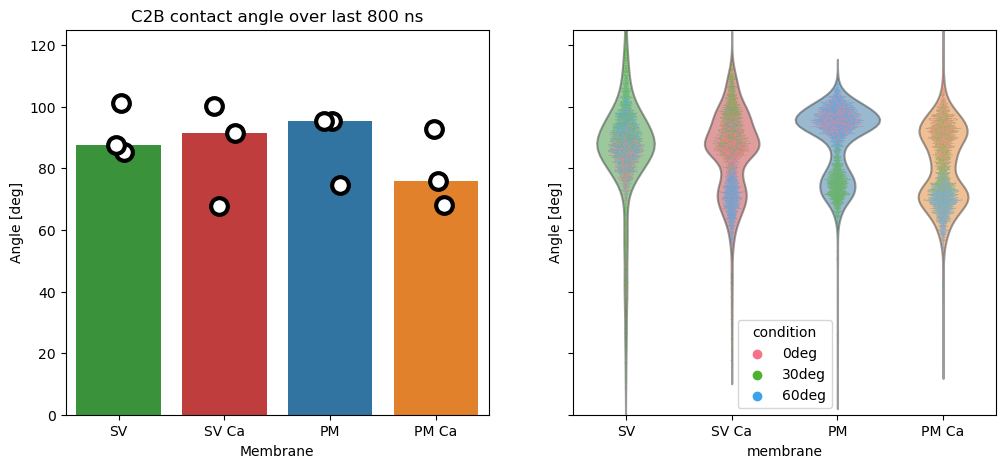

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharey='all')

sns.barplot(d,
            x='Membrane', y='Angle [deg]',
            errorbar=None, estimator='median',
            palette=sns.color_palette("tab10")[2:4]+sns.color_palette("tab10")[:2],
            dodge=True,
            ax=ax[0])

#for patch in ax.patches:
#    clr = patch.get_facecolor()
#    patch.set_edgecolor(clr)
#    patch.set_facecolor((0,0,0,0))

sns.stripplot(d,
    x='Membrane', y='Angle [deg]',
    edgecolor='#000000',
    fc='#ffffff',
    linewidth=3,
    size=12,
    legend=False,
    ax=ax[0])
 
ax[0].set_title(f'C2B contact angle over last {sum_last_ns} ns')


sns.violinplot(e,
               x='membrane',
               y='Angle [deg]',
               inner=None,
               order=['SV', 'SV Ca', 'PM', 'PM Ca'],
               palette=sns.color_palette("tab10")[2:4]+sns.color_palette("tab10")[:2],
               ax=ax[1]
              )

for violin in ax[1].collections:
    violin.set_alpha(0.5)

sns.swarmplot(e,
              x='membrane',
              y='Angle [deg]',
              hue='condition',
              order=['SV', 'SV Ca', 'PM', 'PM Ca'],
              palette='husl',
              size=0.5,
              ax=ax[1])
    
ax[1].set_title(None)
plt.ylim(0,125)
plt.savefig("figures/c2b{}to{}ns_angle_catplot_violinplot.pdf".format(start_t, end_t))
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


d = collapsed_angles_df.explode('Medians').reset_index().rename(columns={'index': 'Membrane', 'Medians': 'Angle [deg]'})

ax = sns.barplot(d,
            x='Membrane', y='Angle ''[deg]',
            errorbar=None, estimator='median',
            dodge=True)

for patch in ax.patches:
    clr = patch.get_facecolor()
    patch.set_edgecolor(clr)
    patch.set_facecolor((0,0,0,0))

sns.stripplot(d,
    x='Membrane', y='Angle [deg]',
    hue='Membrane',
    legend=False, ax=ax)
        
plt.title(f'C2B contact angle over last {sum_last_ns} ns')
plt.savefig("figures/c2b{}to{}ns_angle_catplot.pdf".format(start_t, end_t))
plt.show()

In [ ]:
d = angles_df.unstack().reset_index().rename(columns={0:'Angle [deg]'})

ax = sns.violinplot(d,
               x='membrane',
               y='Angle [deg]',
               inner=None,
               order=['PM', 'PM Ca', 'SV', 'SV Ca'],
               alpha="0.5"
              )

for violin in ax.collections:
    violin.set_alpha(0.5)

sns.swarmplot(d,
              x='membrane',
              y='Angle [deg]',
              hue='condition',
              order=['PM', 'PM Ca', 'SV', 'SV Ca'],
              palette='husl',
              size=0.5)
    
plt.title(f'C2B contact angle over last {sum_last_ns} ns')
plt.savefig("figures/c2b{}to{}ns_angle_violinplot.pdf".format(start_t, end_t))
plt.show()